In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import deepcopy

In [2]:
# Parametros
num_islas = 4
tam_pob = 20
periodo_produccion = 10  # En dias
max_produccion = 50  # Maxima produccion por dia en toneladas (10-50)
min_color = 25  # Porcentaje minimo de color (10 - 50)
min_color_periodo = 10  # Minimo porcentaje por cada color en la mitad del periodo de produccion
max_color_periodo = 50  # Maximo porcentaje por cada color en la mitad del periodo de produccion
num_colores = 3  # Numero de Colores (Blanco - Gris - Negro)
seed = 42  # Semilla para reproducibilidad


In [3]:
# Objetivos de produccion para cada (color, grosor)
objetivos_produccion = {
    (0, 0): 50,  # Blanco delgado
    (0, 1): 40,  # Blanco grueso
    (1, 0): 60,  # Gris delgado
    (1, 1): 30,  # Gris grueso
    (2, 0): 70,  # Negro delgado
    (2, 1): 20,  # Negro grueso
}

In [4]:
# Costos Y Precio
precio_color = [200, 220, 250]  # Precio de colores 0, 1 y 2
costo_color = [150, 160, 170]  # Costos de los colores
costo_limpieza = { #Costos por cambio de color
    (0, 1): 50,  # De blanco a Gris 
    (0, 2): 80,  # De blanco a Negro 
    (1, 0): 60,  # De gris a blanco 
    (1, 2): 40,  # De gris a Negro 
    (2, 0): 120, # De Negro a blanco 
    (2, 1): 30   # De Negro a Gris 
}

precio_grosor = [50, 100]  # Precio por grosor (0) Delgado y (1) grueso
costo_grosor = [30, 60]    # Costo de produccion para dos tipos de grosores
costo_limpieza_grosor = 20 # Costo por cambio de grosor

penalizacion_por_color = [500, 600, 700]  # Penalizacion Por Insuficiencia en el inventario

In [5]:
def crear_individuo():
    return {
        "Produccion": np.random.randint(10, max_produccion + 1, size=periodo_produccion),
        "Colores": np.random.randint(0, num_colores, size=periodo_produccion),
        "Grosores": np.random.randint(0, 2, size=periodo_produccion)
    }

In [6]:
# Inicializar Poblacion Para Todas las Islas
def inicializar_islas(num_islas, tam_pob, seed = None):
    if seed is not None:
        np.random.seed(seed)
        
    islas = []
    for i in range(num_islas):
        island_seed = None if seed is None else seed + i
        poblacion = [crear_individuo() for _ in range(tam_pob)]
        islas.append(poblacion)
    return islas

In [7]:
# Funcion de Aptitud Mejorada
# Funcion de Aptitud Mejorada
def obtener_aptitud(individuo):
    produccion = individuo["Produccion"]
    colores = individuo["Colores"]
    grosores = individuo["Grosores"]

    ingreso_total = 0
    costo_total = 0

    # Calculate revenues and costs per day
    for cantidad, color, grosor in zip(produccion, colores, grosores):
        if cantidad > max_produccion:
            # Penalizar sobreproduccion
            costo_total += (cantidad - max_produccion) * 100
            cantidad = max_produccion

        ingreso_total += cantidad * (precio_color[color] + precio_grosor[grosor])
        costo_total += cantidad * (costo_color[color] + costo_grosor[grosor])

    # Add cleaning costs for color and thickness changes
    for i in range(1, len(produccion)):
        if colores[i] != colores[i - 1]:
            costo_total += costo_limpieza.get((colores[i - 1], colores[i]), 100)
        if grosores[i] != grosores[i - 1]:
            costo_total += costo_limpieza_grosor

    # Check color quotas for the entire period
    produccion_total = sum(produccion)
    total_colores = [0] * num_colores
    for color, cantidad in zip(colores, produccion):
        total_colores[color] += cantidad

    for color, total in enumerate(total_colores):
        if total < produccion_total * (min_color / 100):
            costo_total += penalizacion_por_color[color]  # Penalize unmet quotas

    # Check production objectives
    objetivos_penalizacion = 500  # Penalty for under/overproduction per ton
    produccion_objetivos = {key: 0 for key in objetivos_produccion}

    for cantidad, color, grosor in zip(produccion, colores, grosores):
        produccion_objetivos[(color, grosor)] += cantidad

    for (color, grosor), objetivo in objetivos_produccion.items():
        actual_production = produccion_objetivos[(color, grosor)]
        if actual_production < objetivo:
            # Penalize for underproduction
            costo_total += (objetivo - actual_production) * objetivos_penalizacion
        elif actual_production > objetivo:
            # Penalize for overproduction
            costo_total += (actual_production - objetivo) * objetivos_penalizacion

    # Fitness is the difference between revenues and costs
    return float(ingreso_total - costo_total)

In [8]:
def torneo_aleatorio(poblacion, aptitud, k=2):
    if len(poblacion) < k:
        raise ValueError("Population size is smaller than the tournament size.")
    seleccion = random.sample(list(zip(poblacion, aptitud)), k)
    return max(seleccion, key=lambda x: x[1])[0]  # Return the individual with the highest fitness


In [9]:
def ruleta(poblacion, aptitudes):
    aptitud_total = sum(aptitudes)
    if aptitud_total == 0:
        raise ValueError("Total fitness is zero. Cannot perform roulette selection.")
    eleccion = random.uniform(0, aptitud_total)
    actual = 0
    for individuo, aptitud in zip(poblacion, aptitudes):
        actual += aptitud
        if actual > eleccion:
            return individuo
    # Fallback in case of rounding errors
    return poblacion[-1]


In [10]:
def seleccion_truncada(poblacion, aptitudes, truncation_rate=0.5):
    # Sort individuals by fitness (descending order)
    sorted_population = [ind for _, ind in sorted(zip(aptitudes, poblacion), key=lambda x: x[0], reverse=True)]

    # Select the top `p%`
    num_selected = int(len(sorted_population) * truncation_rate)
    truncated_population = sorted_population[:num_selected]

    # Randomly choose one from the truncated population
    return random.choice(truncated_population)

In [11]:
# Single-point crossover
def cruza_punto(padre1, padre2):
    punto = random.randint(1, len(padre1["Produccion"]) - 1)

    hijo1 = {
        "Produccion": np.concatenate((padre1["Produccion"][:punto], padre2["Produccion"][punto:])),
        "Colores": np.concatenate((padre1["Colores"][:punto], padre2["Colores"][punto:])),
        "Grosores": np.concatenate((padre1["Grosores"][:punto], padre2["Grosores"][punto:]))
    }
    hijo2 = {
        "Produccion": np.concatenate((padre2["Produccion"][:punto], padre1["Produccion"][punto:])),
        "Colores": np.concatenate((padre2["Colores"][:punto], padre1["Colores"][punto:])),
        "Grosores": np.concatenate((padre2["Grosores"][:punto], padre1["Grosores"][punto:]))
    }
    return hijo1, hijo2

In [12]:
def uniforme(padre1, padre2):
    # Initialize children with empty arrays of the same size as parents
    size = len(padre1["Produccion"])
    hijo1 = {
        "Produccion": np.zeros(size, dtype=int),
        "Colores": np.zeros(size, dtype=int),
        "Grosores": np.zeros(size, dtype=int),
    }
    hijo2 = {
        "Produccion": np.zeros(size, dtype=int),
        "Colores": np.zeros(size, dtype=int),
        "Grosores": np.zeros(size, dtype=int),
    }

    # Perform uniform crossover
    for i, (p1, p2, c1, c2, g1, g2) in enumerate(zip(
        padre1["Produccion"], padre2["Produccion"],
        padre1["Colores"], padre2["Colores"],
        padre1["Grosores"], padre2["Grosores"]
    )):
        if random.random() < 0.5:
            hijo1["Produccion"][i], hijo2["Produccion"][i] = p1, p2
            hijo1["Colores"][i], hijo2["Colores"][i] = c1, c2
            hijo1["Grosores"][i], hijo2["Grosores"][i] = g1, g2
        else:
            hijo1["Produccion"][i], hijo2["Produccion"][i] = p2, p1
            hijo1["Colores"][i], hijo2["Colores"][i] = c2, c1
            hijo1["Grosores"][i], hijo2["Grosores"][i] = g2, g1

    return hijo1, hijo2


In [13]:
def mutar_poblacion(poblacion, mutation_rate=1.0, porcentaje=0.25):
    aptitudes = [obtener_aptitud(ind) for ind in poblacion]
    poblacion_ordenada = sorted(zip(aptitudes, poblacion), key=lambda x: x[0])

    # Select bottom X% for mutation
    num_mutar = int(len(poblacion) * porcentaje)
    individuos_a_mutar = [ind for _, ind in poblacion_ordenada[:num_mutar]]

    # Apply mutation to only the selected individuals
    for individuo in individuos_a_mutar:
        for i in range(len(individuo["Produccion"])):
            if random.random() < mutation_rate:
                individuo["Produccion"][i] = random.randint(1, max_produccion)
                individuo["Colores"][i] = random.randint(0, num_colores - 1)
                individuo["Grosores"][i] = random.randint(0, 1)

    return poblacion  # Ensure population size remains unchanged


In [14]:
# Evolve a single island
def evolucionar_isla(poblacion, generaciones, seleccion, cruza, tasa_cruce=0.8, tasa_mutacion=0.2):
    tam_pob = len(poblacion)  # Initial population size

    for _ in range(generaciones):
        aptitudes = [obtener_aptitud(ind) for ind in poblacion]

        # Selection and generate new offspring
        nueva_poblacion = []
        for _ in range(tam_pob // 2):  # Each pair produces two offspring
            padre1 = seleccion(poblacion, aptitudes)
            padre2 = seleccion(poblacion, aptitudes)

            # Apply crossover with a probability
            if random.random() < tasa_cruce:
                hijo1, hijo2 = cruza(padre1, padre2)
            else:
                hijo1, hijo2 = padre1, padre2

            nueva_poblacion.extend([hijo1, hijo2])

        # Apply mutation to the offspring
        nueva_poblacion = mutar_poblacion(nueva_poblacion, mutation_rate=tasa_mutacion)

        # Combine old population and offspring, and sort by fitness
        poblacion_combinada = poblacion + nueva_poblacion
        aptitudes_combinadas = [obtener_aptitud(ind) for ind in poblacion_combinada]
        poblacion = [
            ind for _, ind in sorted(zip(aptitudes_combinadas, poblacion_combinada), key=lambda x: x[0], reverse=True)
        ][:tam_pob]  # Keep only the best individuals

    return poblacion



In [15]:
def evolucionar_multi_islas(
    islas, seleccion_operadores, generaciones=50, migracion_intervalo=2
):
    # Initialize fitness tracking
    fitness_history = {i: {"mejor": [], "media": []} for i in range(len(islas))}

    for gen in range(generaciones):
        for i, isla in enumerate(islas):
            operadores = seleccion_operadores[i]
            islas[i] = evolucionar_isla(
                isla, generaciones=1, seleccion=operadores["seleccion"], cruza=operadores["cruza"]
            )

            # Calculate fitness statistics for the island
            aptitudes = [obtener_aptitud(ind) for ind in islas[i]]
            fitness_history[i]["mejor"].append(max(aptitudes))  # Best fitness
            fitness_history[i]["media"].append(sum(aptitudes) / len(aptitudes))  # Mean fitness

        if gen % migracion_intervalo == 0 and gen > 0:
            # Perform migration: Swap best individuals between islands
            mejores = [max(isla, key=obtener_aptitud) for isla in islas]
            for i in range(len(islas)):
                siguiente_isla = (i + 1) % len(islas)
                islas[siguiente_isla][0] = deepcopy(mejores[i])  # Replace the worst with the best

    # Aggregate results from all islands
    todas_islas = [ind for isla in islas for ind in isla]
    mejor_solucion = max(todas_islas, key=obtener_aptitud)

    return mejor_solucion, fitness_history

In [16]:
def plot_fitness(fitness_history):
    plt.figure(figsize=(14, 7))

    # Plot fitness for each island
    for island, history in fitness_history.items():
        generations = range(len(history["mejor"]))
        plt.plot(generations, history["mejor"], label=f"Isla {island} - Mejor Aptitud")
        plt.plot(generations, history["media"], label=f"Isla {island} - Aptitud Media", linestyle="--")

    # Customize plot
    plt.title("Evolución de la Aptitud por Generación", fontsize=16)
    plt.xlabel("Generaciones", fontsize=14)
    plt.ylabel("Aptitud", fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()


Mejor Solución: {'Produccion': array([44, 30, 26, 35, 17, 38, 22, 23, 23, 13]), 'Colores': array([2, 0, 2, 1, 0, 1, 0, 1, 0, 2]), 'Grosores': array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1])}
Aptitud: 16030.0


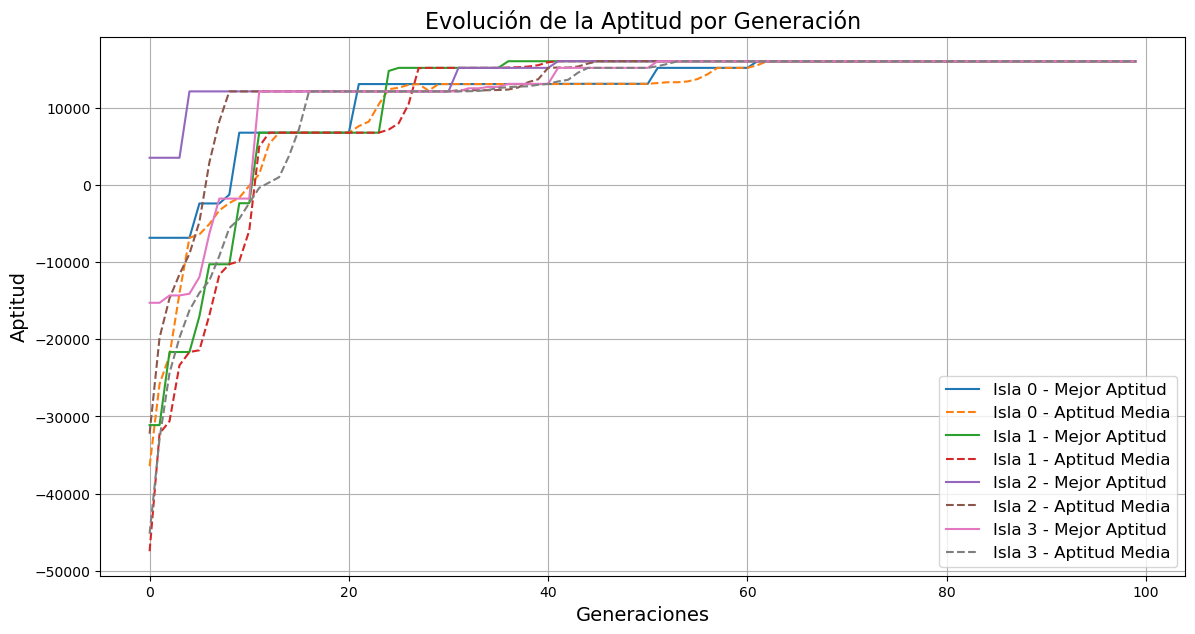

In [17]:
islas = inicializar_islas(num_islas, tam_pob, seed)

    # Define operators for each island
seleccion_operadores = [
    {"seleccion": torneo_aleatorio, "cruza": cruza_punto},
    {"seleccion": ruleta, "cruza": uniforme},
    {"seleccion": seleccion_truncada, "cruza": cruza_punto},
    {"seleccion": torneo_aleatorio, "cruza": uniforme},
    {"seleccion": ruleta, "cruza": cruza_punto},
    {"seleccion": seleccion_truncada, "cruza": uniforme},
]

# Run multi-island evolution with fitness tracking
mejor_solucion, fitness_history = evolucionar_multi_islas(
        islas, seleccion_operadores, generaciones=100, migracion_intervalo=10
)

# Output the best solution
print("Mejor Solución:", mejor_solucion)
print("Aptitud:", obtener_aptitud(mejor_solucion))

# Plot fitness trends
plot_fitness(fitness_history)